# Import Libraries

In [1]:
import os
import json
import joblib
import mlflow
import mlflow.sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:

def configure_mlflow():
    """
    Optional: configure MLflow to log to DagsHub.
    If you don't set these env vars, it will log locally by default.
    """
    
    mlflow.set_tracking_uri("https://dagshub.com/krichenyoussef/MLops.mlflow")
    os.environ["MLFLOW_TRACKING_USERNAME"] = "krichenyoussef"
    os.environ["MLFLOW_TRACKING_PASSWORD"] = "9e7ef4a8033da85761edf8f51ce132432594d3b7"

    pass


def build_pipeline(model):
    """Preprocess numeric/categorical columns then train model."""
    return Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model),
        ]
    )


# -------------------------
# 1) Load data (example)
# -------------------------
# Replace this with your processed dataset:
# df = pd.read_parquet("data/processed/train.parquet")
# For a runnable demo, we use sklearn's breast cancer dataset.
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df = data.frame
target_col = "target"

X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric/categorical columns (here it's all numeric)
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_cols),
    ],
    remainder="drop"
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# 2) Configure MLflow
# -------------------------
configure_mlflow()
mlflow.set_experiment("fraud-demo-multimodel")

# Candidate models (you can add XGBoost later)
candidates = [
    ("logreg", LogisticRegression(max_iter=2000, n_jobs=None)),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
]

best = {"name": None, "metric": -1.0, "run_id": None, "model_path": None}

# -------------------------
# 3) Train + log to MLflow
# -------------------------
for model_name, model in candidates:
    with mlflow.start_run(run_name=model_name):
        pipe = build_pipeline(model)
        pipe.fit(X_train, y_train)

        # Predict
        y_pred = pipe.predict(X_val)

        # Some models expose predict_proba (for AUC / PR-AUC)
        proba = None
        if hasattr(pipe.named_steps["model"], "predict_proba"):
            proba = pipe.predict_proba(X_val)[:, 1]

        # Metrics
        acc = accuracy_score(y_val, y_pred)
        mlflow.log_metric("accuracy", acc)

        if proba is not None:
            roc = roc_auc_score(y_val, proba)
            pr_auc = average_precision_score(y_val, proba)
            mlflow.log_metric("roc_auc", roc)
            mlflow.log_metric("pr_auc", pr_auc)
            main_metric = pr_auc  # better for imbalanced problems like fraud
        else:
            main_metric = acc

        # Params
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("target", target_col)

        # Log model (MLflow artifact)
        mlflow.sklearn.log_model(pipe, artifact_path="model")

        # Also save local artifact for convenience (optional)
        os.makedirs("models", exist_ok=True)
        local_path = f"models/{model_name}.joblib"
        joblib.dump(pipe, local_path)
        mlflow.log_artifact(local_path)

        # Keep best
        run_id = mlflow.active_run().info.run_id
        if main_metric > best["metric"]:
            best.update(
                {"name": model_name, "metric": float(main_metric), "run_id": run_id, "model_path": local_path}
            )

# -------------------------
# 4) Save the "best model" summary
# -------------------------
os.makedirs("models", exist_ok=True)
best_summary_path = "models/best_model.json"
with open(best_summary_path, "w", encoding="utf-8") as f:
    json.dump(best, f, indent=2)

print("✅ Best model:", best)
print("Saved best summary to:", best_summary_path)


2025/12/20 15:05:25 INFO mlflow.tracking.fluent: Experiment with name 'fraud-demo-multimodel' does not exist. Creating a new experiment.
C:\Users\Youss\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/12/20 15:05:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/20 15:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run logreg at: https://dagshub.com/krichenyoussef/MLops.mlflow/#/experiments/0/runs/edf259d684c74b3f8cbd453688a98e27
🧪 View experiment at: https://dagshub.com/krichenyoussef/MLops.mlflow/#/experiments/0


2025/12/20 15:06:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/20 15:06:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/krichenyoussef/MLops.mlflow/#/experiments/0/runs/8e464241819548ebb8da09824e554f61
🧪 View experiment at: https://dagshub.com/krichenyoussef/MLops.mlflow/#/experiments/0
✅ Best model: {'name': 'logreg', 'metric': 0.9973855810756496, 'run_id': 'edf259d684c74b3f8cbd453688a98e27', 'model_path': 'models/logreg.joblib'}
Saved best summary to: models/best_model.json


In [2]:
path_tr_t = "data\\raw\\train_transaction.csv"
path_tr_i = "data\\raw\\train_identity.csv"
path_te_t = "data\\raw\\test_transaction.csv"
path_te_i = "data\\raw\\test_identity.csv"

In [3]:
import pandas as pd

# --- TRAIN ---
train_tr = pd.read_csv(path_tr_t)
train_id = pd.read_csv(path_tr_i)

# sanity checks (optional but useful)
assert train_tr["TransactionID"].is_unique
assert train_id["TransactionID"].is_unique  # should be unique in this dataset

train = train_tr.merge(train_id, on="TransactionID", how="left")

print(train.shape)


(590540, 434)


In [4]:
# --- TEST ---
test_tr = pd.read_csv(path_te_t)
test_id = pd.read_csv(path_te_i)

assert test_tr["TransactionID"].is_unique
assert test_id["TransactionID"].is_unique

test = test_tr.merge(test_id, on="TransactionID", how="left")

print(test.shape)


(506691, 433)


In [5]:
# % of transactions with identity info (not null in an identity column)
id_cols = [c for c in train.columns if c.startswith("id_")]
coverage = train[id_cols].notna().any(axis=1).mean()
print("Identity coverage:", coverage)


Identity coverage: 0.2442391709283029


In [8]:
n = range(1000000)
data = "".join(f"Hello, World!{i} \n" for i in n)   
with open("large_file.txt", "w", encoding="utf-8") as f:
    f.write(data)   

In [9]:
def read_large_file(file_object):
    """A generator to read a large file lazily."""
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data

In [16]:
file_object = open("large_file.txt", "r", encoding="utf-8")
df = read_large_file(file_object)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

INPUT_DIR = 'data/raw/'
COLS_TO_SHOW = 150

def h(content):
    display(HTML(content))

def timehist1(col):
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # clip trans amount for better view
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc1(col):
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud'] == 1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud'] == 0, col], col, 'Train Not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0] * 0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
        display(dd)

def hist1(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70)
    plt.title('Train histogram: ' + col)
    plt.subplot(122)
    plt.hist(te[col], bins=70)
    plt.title('Test histogram: ' + col)
    plt.show()

def corr1(col):
    N = None #10000
    num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
    trx = tr.head(N) if N is not None else tr.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))
    
def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col) 
    
def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)
        
tr = pd.read_csv(INPUT_DIR + 'train_transaction.csv')
te = pd.read_csv(INPUT_DIR + 'test_transaction.csv')
trid = pd.read_csv(INPUT_DIR + 'train_identity.csv')
teid = pd.read_csv(INPUT_DIR + 'test_identity.csv')

included_cols = list(tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
h('Train transactions shape: <b>' + str(tr.shape) + '</b>, identity <b>' + str(trid.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te.shape) + '</b>, identity <b>' + str(teid.shape) + '</b>')
h('Train transactions preview:')
display(tr.head(10))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


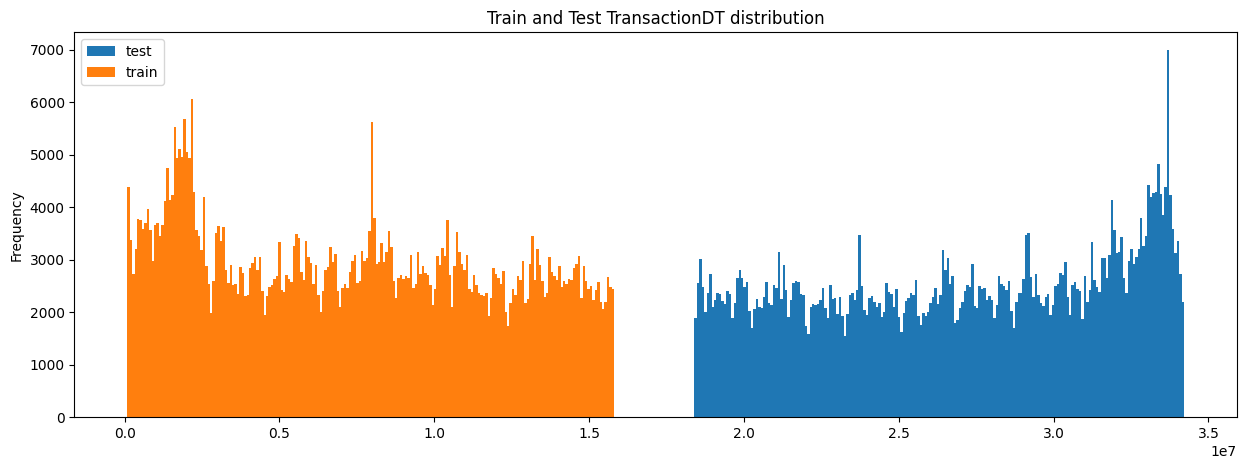

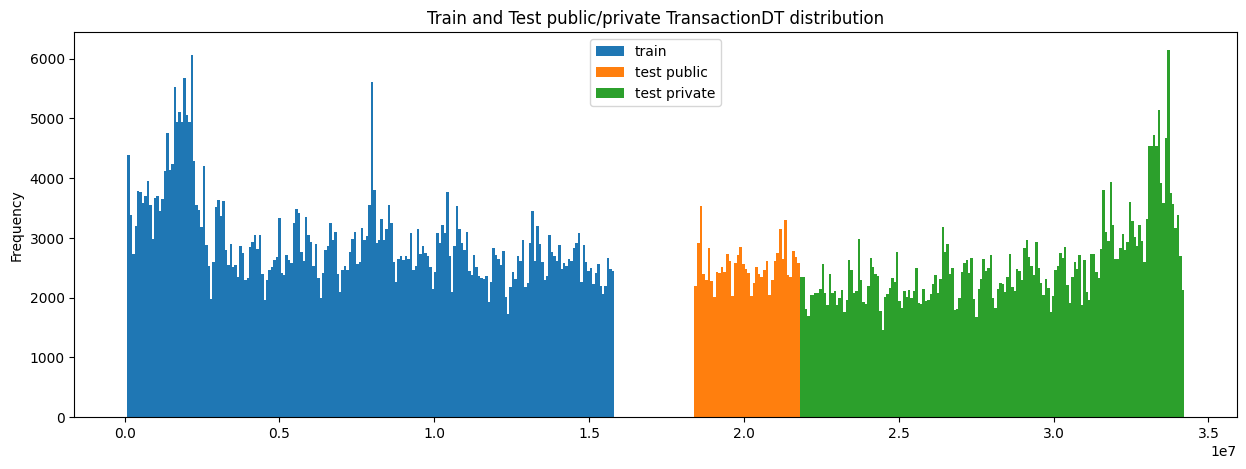

,Column,Correlation with TransactionDT
0,TransactionDT,1.000000
1,TransactionID,0.998280
2,V330,0.258603
3,V326,0.257295
4,V329,0.252599
5,V327,0.248494
375,V145,-0.252731
376,V160,-0.265566
377,V159,-0.279138
378,V151,-0.280576


In [25]:
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

te['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()
tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te.shape[0] * 0.2)
te.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()
corr1(COL)

In [27]:
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
trx = tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 8)
display(trx)
corr1(COL)


,Count,count,Share
0,0,569877,0.0
1,1,20663,1.0


,Column,Correlation with isFraud
0,isFraud,1.000000
1,V257,0.383060
2,V246,0.366878
3,V244,0.364129
4,V242,0.360590
5,V201,0.328005
375,V90,-0.110168
376,V49,-0.110920
377,V48,-0.115786
378,D7,-0.127199


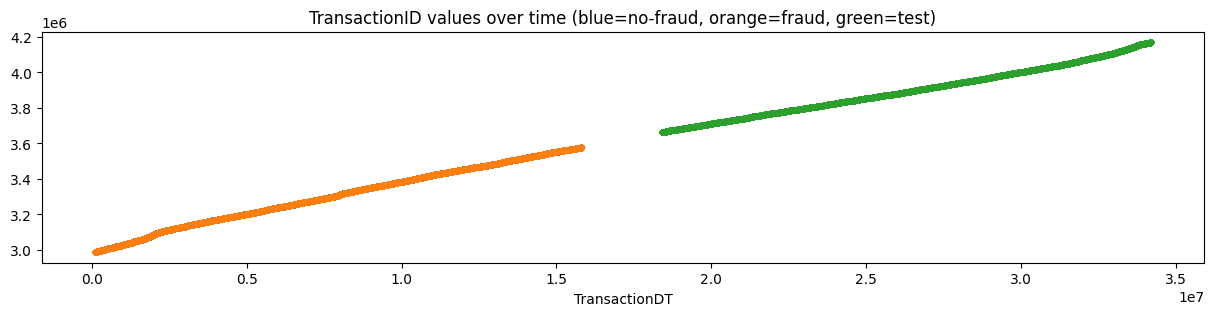

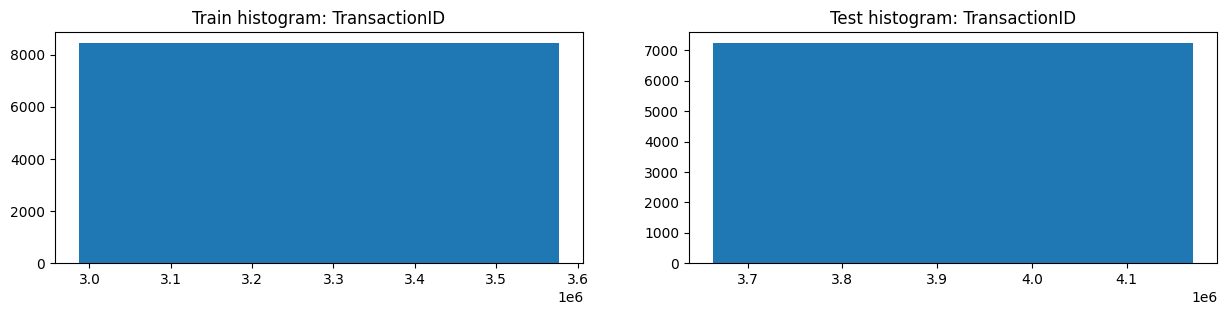

AttributeError: 'DataFrame' object has no attribute 'append'

In [28]:
for col in list(tr.columns.values[:COLS_TO_SHOW]):
    proc(col)

In [31]:
train.TransactionDT/86400

0           1.000000
1           1.000012
2           1.000799
3           1.001146
4           1.001227
             ...    
590535    182.998229
590536    182.998252
590537    182.998600
590538    182.998704
590539    182.999201
Name: TransactionDT, Length: 590540, dtype: float64

SyntaxError: invalid decimal literal (3639038546.py, line 1)